In [2]:
# import table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as ra
import json
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F

from dp_processor import Processor
from dp_wgan import Generator, Discriminator
from dp_autoencoder import Autoencoder
import dp_optimizer, sampling, analysis

from pm4py.objects.log.importer.xes import importer
from pm4py.algo.filtering.log.variants import variants_filter

from dpv.data_utility import emd_utility, log_diff


# settings
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# import xes event log (BPIC2012 example)
log = importer.apply('BPI2012App.xes')

parsing log, completed traces :: 100%|██████████| 13087/13087 [00:07<00:00, 1741.55it/s]


In [4]:
# extract variants
variants = variants_filter.get_variants(log)

# number of variants
len(variants)

17

In [584]:
# create dataframe
var_log = []

for var in variants:
    var_log += [var] * len(variants[var])
    
ra.shuffle(var_log)
df = pd.DataFrame({'variant': var_log})
df_orig = pd.DataFrame({'orig': var_log})
df

,variant
0,"A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,A_..."
1,"A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,A_..."
2,"A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,A_..."
3,"A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,A_..."
4,"A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,A_..."
...,...
13082,"A_SUBMITTED,A_PARTLYSUBMITTED,A_DECLINED"
13083,"A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,A_..."
13084,"A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,A_..."
13085,"A_SUBMITTED,A_PARTLYSUBMITTED,A_DECLINED"


In [585]:
# init data processor
datatypes = [('variant', 'categorical')]
processor = Processor(datatypes)

# encode categories
for column, datatype in datatypes:
    if 'categorical' in datatype:
        df[column] = df[column].astype('category').cat.codes

# init training data
train_df = df.head(int(len(df)*0.98))
train_cutoff = int(len(df)*0.98)

# create tensor data
X_real = torch.tensor(df.values, dtype=torch.float32)
X_encoded = torch.tensor(processor.fit_transform(X_real), dtype=torch.float32)

# create train / test tensors
X_train_real = X_real[:train_cutoff]
X_test_real = X_real[train_cutoff:]

# create encoded train / test tensors
X_train_encoded = X_encoded[:train_cutoff]
X_test_encoded = X_encoded[train_cutoff:]

# print preview
print(X_train_encoded, X_train_encoded.shape)
print(X_test_encoded, X_test_encoded.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]]) torch.Size([12825, 17])
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]]) torch.Size([262, 17])


In [586]:
# autoencoder config
ae_params = {
    'b1': 0.9,
    'b2': 0.999,
    'binary': True,
    'compress_dim': 15,
    'delta': 1e-6,
    'device': 'cpu',
    'iterations': 20000,
    'lr': 0.005,
    'l2_penalty': 0.,
    'l2_norm_clip': 0.012,
    'minibatch_size': 32,
    'microbatch_size': 1,
    'noise_multiplier': 18,
    'nonprivate': True,
}

# OPTIMIZED HYPERPARAMETER

# 0.01
# 2 : 1.4, 64, 20000
# 1 : 2.4, 64, 20000
# 0.1 : 10, 32, 25000
# 0.01: 50, 32, 25000

# 0.001
# 2: 1.6 64 20k
# 1: 2.6 64 20k
# 0.1: 10 32 25k
# 0.01: 60 32 25k

# 0.0001
# 2: 1.8, 64, 20k
# 1: 3.6, 64, 20k
# 0.1: 15, 32, 25k
# 0.01: 70, 32, 25k

# -5
# 2: 2.1 64 25k
# 1: 4 64 25k
# 0.1: 15 32 25k
# 0.01: 80 32 25k

# -6
# 2: 2.3 64 25k
# 1: 4 64 25k
# 0.1: 18 32 25k
# 0.01: 150 32 20k

# init autoencoder
autoencoder = Autoencoder(
    example_dim=len(X_train_encoded[0]),
    compression_dim=ae_params['compress_dim'],
    binary=ae_params['binary'],
    device=ae_params['device'],
)

# init decoding optimizer
decoder_optimizer = dp_optimizer.DPAdam(
    l2_norm_clip=ae_params['l2_norm_clip'],
    noise_multiplier=ae_params['noise_multiplier'],
    minibatch_size=ae_params['minibatch_size'],
    microbatch_size=ae_params['microbatch_size'],
    nonprivate=ae_params['nonprivate'],
    params=autoencoder.get_decoder().parameters(),
    lr=ae_params['lr'],
    betas=(ae_params['b1'], ae_params['b2']),
    weight_decay=ae_params['l2_penalty'],
)

# init encoding optimizer
encoder_optimizer = torch.optim.Adam(
    params=autoencoder.get_encoder().parameters(),
    lr=ae_params['lr'] * ae_params['microbatch_size'] / ae_params['minibatch_size'],
    betas=(ae_params['b1'], ae_params['b2']),
    weight_decay=ae_params['l2_penalty'],
)

In [587]:
"""
weights, ds = [], []
for name, datatype in datatypes:
    if 'categorical' in datatype:
        num_values = len(np.unique(df[name]))
        if num_values == 2:
            weights.append(1.)
            ds.append((datatype, 1))
        else:
            for i in range(num_values):
                weights.append(1. / num_values)
            ds.append((datatype, num_values))
    else:
        weights.append(1.)
        ds.append((datatype, 1))
weights = torch.tensor(weights).to(ae_params['device'])
"""

# define loss
#autoencoder_loss = (lambda input, target: torch.mul(weights, torch.pow(input-target, 2)).sum(dim=1).mean(dim=0))
#autoencoder_loss = lambda input, target: torch.mul(weights, F.binary_cross_entropy(input, target, reduction='none')).sum(dim=1).mean(dim=0)
autoencoder_loss = nn.BCELoss()
#autoencoder_loss = nn.MSELoss()

# print network structure
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=15, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=17, bias=True)
    (3): Sigmoid()
  )
)


In [588]:
# DP parameter analysis
print('Achieves ({}, {})-DP'.format(
    analysis.epsilon(
        len(X_train_encoded),
        ae_params['minibatch_size'],
        ae_params['noise_multiplier'],
        ae_params['iterations'],
        ae_params['delta']
    ),
    ae_params['delta'],
))

Achieves (0.10342505562755817, 1e-06)-DP


In [589]:
# init data loader
minibatch_loader, microbatch_loader = sampling.get_data_loaders(
    minibatch_size=ae_params['minibatch_size'],
    microbatch_size=ae_params['microbatch_size'],
    iterations=ae_params['iterations'],
    nonprivate=ae_params['nonprivate'],
)

[Iteration 0/20000] [Loss: 0.722056] [Validation Loss: 0.723094]
[Iteration 1000/20000] [Loss: 0.143994] [Validation Loss: 0.153850]
[Iteration 2000/20000] [Loss: 0.067557] [Validation Loss: 0.083046]
[Iteration 3000/20000] [Loss: 0.033840] [Validation Loss: 0.038739]
[Iteration 4000/20000] [Loss: 0.017859] [Validation Loss: 0.017983]
[Iteration 5000/20000] [Loss: 0.005987] [Validation Loss: 0.010390]
[Iteration 6000/20000] [Loss: 0.009199] [Validation Loss: 0.006711]
[Iteration 7000/20000] [Loss: 0.004999] [Validation Loss: 0.004646]
[Iteration 8000/20000] [Loss: 0.004586] [Validation Loss: 0.003736]
[Iteration 9000/20000] [Loss: 0.001824] [Validation Loss: 0.003204]
[Iteration 10000/20000] [Loss: 0.003032] [Validation Loss: 0.002809]
[Iteration 11000/20000] [Loss: 0.005613] [Validation Loss: 0.002392]
[Iteration 12000/20000] [Loss: 0.001626] [Validation Loss: 0.002240]
[Iteration 13000/20000] [Loss: 0.001914] [Validation Loss: 0.001995]
[Iteration 14000/20000] [Loss: 0.001181] [Valid

<AxesSubplot:>

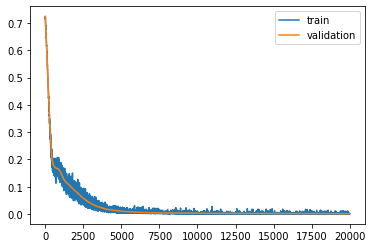

In [590]:
# train autoencoder
train_losses, validation_losses = [], []

X_train_encoded = X_train_encoded.to(ae_params['device'])
X_test_encoded = X_test_encoded.to(ae_params['device'])

for iteration, X_minibatch in enumerate(minibatch_loader(X_train_encoded)):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    for X_microbatch in microbatch_loader(X_minibatch):

        decoder_optimizer.zero_microbatch_grad()
        output = autoencoder(X_microbatch)
        loss = autoencoder_loss(output, X_microbatch)
        loss.backward()
        decoder_optimizer.microbatch_step()
        
    validation_loss = autoencoder_loss(autoencoder(X_test_encoded).detach(), X_test_encoded)
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    train_losses.append(loss.item())
    validation_losses.append(validation_loss.item())

    if iteration % 1000 == 0:
        print ('[Iteration %d/%d] [Loss: %f] [Validation Loss: %f]' % (
            iteration, ae_params['iterations'], loss.item(), validation_loss.item())
        )

pd.DataFrame(data={'train': train_losses, 'validation': validation_losses}).plot()

In [580]:
# save autoencoder
with open('models/model_12_ae_0.01_0.001.dat', 'wb') as f:
    torch.save(autoencoder, f)

In [255]:
# load autoencoder
with open('models/model_12_ae_0.01_0.000001.dat', 'rb') as f:
    autoencoder = torch.load(f)


In [559]:
# extract decoder
decoder = autoencoder.get_decoder()

In [560]:
# GAN config
gan_params = {
    'alpha': 0.99,
    'binary': True,
    'clip_value': 0.01,
    'd_updates': 15,
    'delta': 1e-3,
    'device': 'cpu',
    'iterations': 50,
    'latent_dim': 64,
    'lr': 0.005,
    'l2_penalty': 0.,
    'l2_norm_clip': 0.022,
    'minibatch_size': 128,
    'microbatch_size': 1,
    'noise_multiplier': 70,
    'nonprivate': False,
}

# OPTIMIZED HYPERPARAMETER

# 0.01 noise minibatch iter
# 2: 1.3, 64, 15000
# 1: 2.3, 64, 15000
# 0.1: 50, 512, 3000
# 0.01: 70, 128, 3000

# 0.001
# 2: 1.7 256 1500
# 1: 2.7 256 1500
# 0.1: 25 256 1500
# 0.01: 70 128 50

# 0.0001
# 2: 1.7, 64, 15k
# 1: 3, 64, 15k
# 0.1: 10, 512, 20
# 0.01: 60, 512, 40

# -5
# 2: 2.1 265 1500
# 1: 4 265 1500
# 0.1: 4 128 40 
# 0.01: 140 128 2000

# -6
# 2: 2.3 256 1500
# 1: 4 256 1500
# 0.1: 20 128 1500
# 0.01: 140 128 2000

generator = Generator(
    input_dim=gan_params['latent_dim'],
    output_dim=autoencoder.get_compression_dim(),
    binary=gan_params['binary'],
    device=gan_params['device'],
)

g_optimizer = torch.optim.RMSprop(
    params=generator.parameters(),
    lr=gan_params['lr'],
    alpha=gan_params['alpha'],
    weight_decay=gan_params['l2_penalty'],
)

discriminator = Discriminator(
    input_dim=len(X_train_encoded[0]),
    device=gan_params['device'],
)

d_optimizer = dp_optimizer.DPRMSprop(
    l2_norm_clip=gan_params['l2_norm_clip'],
    noise_multiplier=gan_params['noise_multiplier'],
    minibatch_size=gan_params['minibatch_size'],
    microbatch_size=gan_params['microbatch_size'],
    nonprivate=gan_params['nonprivate'],
    params=discriminator.parameters(),
    lr=gan_params['lr'],
    alpha=gan_params['alpha'],
    weight_decay=gan_params['l2_penalty'],
)

#print(generator)
#print(discriminator)

In [561]:
# privacy analysis
print('Achieves ({}, {})-DP'.format(
    analysis.epsilon(
        len(X_train_encoded),
        gan_params['minibatch_size'],
        gan_params['noise_multiplier'],
        gan_params['iterations'],
        gan_params['delta']
    ),
    gan_params['delta'],
))

Achieves (0.013778613747352375, 0.001)-DP


In [562]:
# create data loader
minibatch_loader, microbatch_loader = sampling.get_data_loaders(
    minibatch_size=gan_params['minibatch_size'],
    microbatch_size=gan_params['microbatch_size'],
    iterations=gan_params['iterations'],
    nonprivate=gan_params['nonprivate'],
)

[Iteration 0/50] [D loss: -0.023904] [G loss: 0.000283]


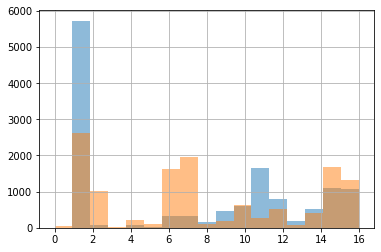

[Iteration 10/50] [D loss: 0.000001] [G loss: 0.000283]


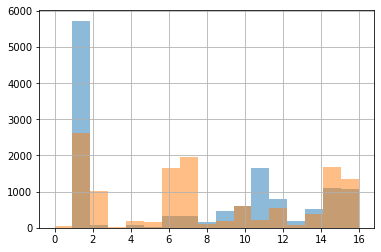

[Iteration 20/50] [D loss: 0.000005] [G loss: -0.009953]


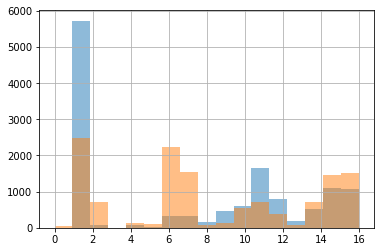

[Iteration 30/50] [D loss: -0.000001] [G loss: -0.006864]


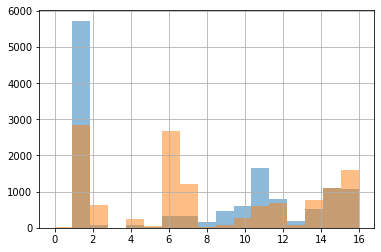

[Iteration 40/50] [D loss: -0.000005] [G loss: -0.006864]


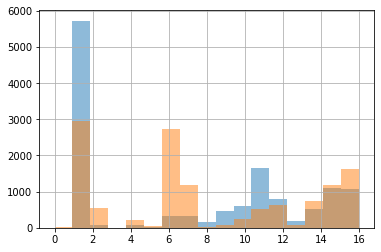

In [563]:
# train GAN
X_train_encoded = X_train_encoded.to(gan_params['device'])
X_test_encoded = X_test_encoded.to(ae_params['device'])

for iteration, X_minibatch in enumerate(minibatch_loader(X_train_encoded)):
    
    d_optimizer.zero_grad()
    
    for real in microbatch_loader(X_minibatch):
        z = torch.randn(real.size(0), gan_params['latent_dim'], device=gan_params['device'])
        fake = decoder(generator(z)).detach()
        
        d_optimizer.zero_microbatch_grad()
        d_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
        d_loss.backward()
        d_optimizer.microbatch_step()
    
    d_optimizer.step()

    for parameter in discriminator.parameters():
        parameter.data.clamp_(-gan_params['clip_value'], gan_params['clip_value'])

    if iteration % gan_params['d_updates'] == 0:
        z = torch.randn(X_minibatch.size(0), gan_params['latent_dim'], device=gan_params['device'])
        fake = decoder(generator(z))

        g_optimizer.zero_grad()
        g_loss = -torch.mean(discriminator(fake))
        g_loss.backward()
        g_optimizer.step()

    if iteration % 10 == 0:
        print('[Iteration %d/%d] [D loss: %f] [G loss: %f]' % (
            iteration, gan_params['iterations'], d_loss.item(), g_loss.item()
        ))
        
        z = torch.randn(len(X_train_real), gan_params['latent_dim'], device=gan_params['device'])
        X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()
        X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
        X_synthetic_encoded = processor.transform(X_synthetic_real)
        synthetic_data = pd.DataFrame(X_synthetic_real, columns=df.columns)

        i = 0
        columns = df.columns
        df[columns[i]].hist(bins=17, alpha=0.5)
        synthetic_data[columns[i]].hist(bins=17, alpha=0.5)
        plt.show()

In [578]:
# save GAN
with open('models/model_12_gan_0.01_0.001.dat', 'wb') as f:
    torch.save(generator, f)

In [564]:
# create mapping
mapping = dict(enumerate(df_orig['orig'].astype('category').cat.categories))

In [ ]:
# save and load GAN
with open('models/model_12_gan_0.1_0.01.dat', 'rb') as f:
    generator = torch.load(f)
    
with open('models/model_12_ae_0.1_0.01.dat', 'rb') as f:
    autoencoder = torch.load(f)

In [569]:
# create synthetic data log
decoder = autoencoder.get_decoder()

#z = torch.randn(13087*100, gan_params['latent_dim'], device=gan_params['device'])
z = torch.randn(13087*100, 64, device='cpu')
X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()
X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
synthetic_data = pd.DataFrame(X_synthetic_real, columns=df.columns)

In [570]:
# example debugging output
df['variant'].value_counts()

1     5719
11    1640
15    1100
16    1085
12     802
10     590
14     532
9      465
6      327
7      322
13     183
8      154
2       69
4       66
5       29
3        3
0        1
Name: variant, dtype: int64

In [571]:
# example debugging output
synthetic_data['variant'].value_counts()


1.0     336712
6.0     292118
7.0     138841
15.0    116151
16.0    111843
12.0    107966
2.0      67040
14.0     50313
4.0      26430
11.0     26176
10.0     15880
5.0       7441
13.0      5062
9.0       3696
8.0       2468
0.0        385
3.0        178
Name: variant, dtype: int64

In [572]:
# reverse variant names
def reverse(df, mapping):
    
    var_list = dict()
    
    for var in df:
        
        name = mapping[int(var)]
        
        if name in var_list:
            var_list[name] += 1
        else:
            var_list[name] = 1
    
    return var_list

var_orig = reverse(df['variant'], mapping)
var_priv = reverse(synthetic_data['variant'], mapping)

In [573]:
# align variant numbers for plotting
for var in var_orig:
    
    if var not in var_priv.keys():
        var_priv[var] = 0
        
len(var_priv)

17

<BarContainer object of 17 artists>

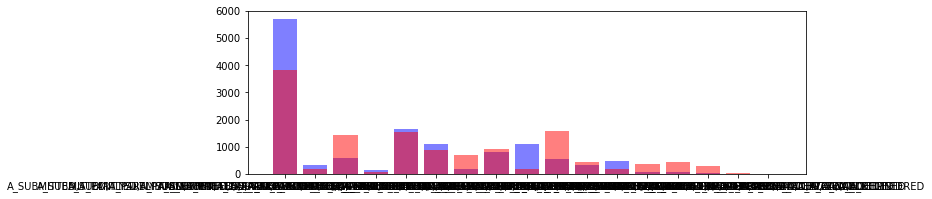

In [385]:
# debugging plots
pri = {k:v/100 for (k, v) in var_priv.items()}
plt.figure(figsize=(10,3))
plt.bar(*zip(*var_orig.items()), color='b', alpha=0.5)
plt.bar(*zip(*pri.items()), color='r', alpha=0.5)

<BarContainer object of 17 artists>

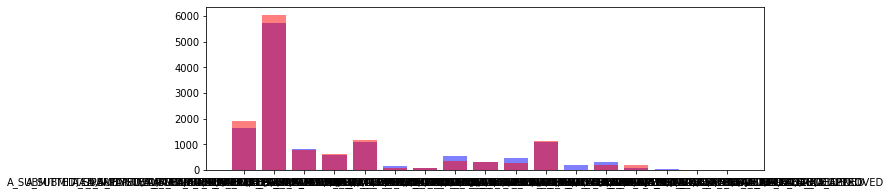

In [24]:
# debugging plots
pri = {k:v/100 for (k, v) in var_priv.items()}
plt.figure(figsize=(10,3))
plt.bar(*zip(*var_orig.items()), color='b', alpha=0.5)
plt.bar(*zip(*pri.items()), color='r', alpha=0.5)

<BarContainer object of 17 artists>

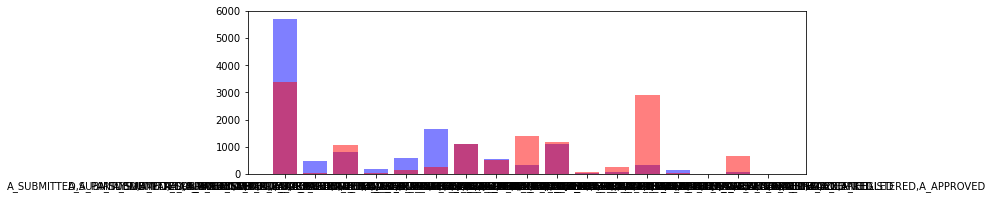

In [574]:
# debugging plots
pri = {k:int(v/100) for (k, v) in var_priv.items()}
plt.figure(figsize=(10,3))
plt.bar(*zip(*var_orig.items()), color='b', alpha=0.5)
plt.bar(*zip(*pri.items()), color='r', alpha=0.5)

In [575]:
# debugging abs log diff
log_diff(var_orig, pri)

9569

In [576]:
# debugging rel log sim
emd_utility(var_orig, pri)

0.86985066620125

In [577]:
# save private logs
fp = open(f"logs/variants_gan_0.01_0.001.json", "w")
json.dump(pri, fp)
fp.close()

In [ ]:
# DATA UTILITY RESULTS

        # 0.01      # 0.001     # 0.0001    # 0.00001   # 0.000001
# 2     0.96           0.94          0.91      0.95         0.95
# 1     0.92           0.95         0.90      0.95          0.9
# 0.1   0.94           0.92          0.94       0.9          0.87
# 0.01  0.90            0.86         0.88       0.85          0.89
# 0.001

In [77]:
# RESULT UTILITY RESULTS

        # 0.01      # 0.001     # 0.0001    # 0.00001   # 0.000001
# 2     7000          5k            6500        4k           6k
# 1     6100          7k           10000       7k           6k
# 0.1   8400          12k          8600        16k          12k     
# 0.01  15000          9k          11622       18k           15k
# 0.001